In [1]:
import os
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchmetrics import Accuracy, MetricCollection, JaccardIndex
import segmentation_models_pytorch as smp
from pytorch_toolbelt.losses import JaccardLoss, BinaryFocalLoss
from torch.utils.data import Dataset, random_split, DataLoader

from pytorch_lightning import Trainer
from typing import Any, Tuple, Optional, Callable, cast

import matplotlib.pyplot as plt
import wandb

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
wandb.login()

wandb: Currently logged in as: sofstef. Use `wandb login --relogin` to force relogin


True

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%load_ext lab_black

In [6]:
os.chdir("/Users/sofija/Ai4er/mres/tree-segmentation")
os.getcwd()

'/Users/sofija/Ai4er/mres/tree-segmentation'

In [7]:
from src.datasets import TreeSegments
from src.evaluation import BinaryIoU
from src.datamodules import TreeDataModule
from src.models import UNet, SegModel
from src.evaluation import LogPredictionSamplesCallback

In [13]:
dm = TreeDataModule(
    data_dir="data/debug_depth/",
    target_dir="data/debug_segment/",
    batch_size=1,
    num_workers=0,
)

In [24]:
dm.setup(stage="fit")
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

In [25]:
for sample in train_dl:
    image = sample[0]
    mask = sample[1]

In [26]:
image.dtype

torch.float32

In [27]:
image.shape

torch.Size([1, 1, 120, 160])

### Metrics

In [55]:
from torchmetrics import Accuracy, MetricCollection, JaccardIndex

In [87]:
a = (torch.rand(torch.Size([1, 1, 120, 160])) > 0.5).float()
b = (torch.rand(torch.Size([1, 120, 160])) > 0.5).int()

Setting up model training


In [37]:
model = SegModel(num_classes=1, lr=0.001)

In [22]:
callbacks = [
    ModelCheckpoint(monitor="train_accuracy", mode="max"),
    ModelCheckpoint(monitor="val_accuracy", mode="max"),
    ModelCheckpoint(monitor="train_jaccard", mode="max"),
    ModelCheckpoint(monitor="val_jaccard", mode="max"),
    LogPredictionSamplesCallback(),
    ModelCheckpoint(monitor="val_loss", mode="max"),
]

In [38]:
# wandb_logger = WandbLogger(
#     project="Trees", log_model="all", name="one_sample_20ep_lr_0.001"
# )

trainer = Trainer(
    # logger=wandb_logger,
    # callbacks=callbacks,
    fast_dev_run=True,
    # max_epochs=10,
)

# wandb_logger.watch(model)

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [39]:
trainer.fit(model=model, datamodule=dm)


  | Name       | Type              | Params
-------------------------------------------------
0 | net        | UNet              | 1.9 M 
1 | loss       | BCEWithLogitsLoss | 0     
2 | train_acc  | Accuracy          | 0     
3 | val_acc    | Accuracy          | 0     
4 | test_acc   | Accuracy          | 0     
5 | train_jacc | JaccardIndex      | 0     
6 | val_jacc   | JaccardIndex      | 0     
7 | test_jacc  | JaccardIndex      | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.457     Total estimated model params size (MB)


Epoch 0:  50%|██████████████████████████████████████                                      | 1/2 [00:00<00:00,  2.77it/s, loss=0.636, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.37it/s, loss=0.636, v_num=]


In [119]:
wandb.finish()

epoch,▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train_accuracy,▁▂▆▇▇▇████
train_jaccard,█▁███████▆
train_loss,▇█▆▃▃▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇██
val_accuracy,█▁▁▃█▇▅▆▇█
val_jaccard,▁██▆▁▁▁▁▁▁
val_loss,▁█▅▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.96536
train_jaccard,0.74865


### Inspecting prediction

In [26]:
dm.setup(stage="predict")

In [27]:
predict_dl = dm.predict_dataloader()

In [28]:
# currently in my predict dataloader I have only the inputs
# so below where I plot I pick the corresponding mask by hand

for sample in predict_dl:
    gtruth = sample[0]

In [29]:
gtruth.shape

torch.Size([1, 120, 160])

In [30]:
test_predict = trainer.predict(model, dm)

/Users/sofija/miniforge3/envs/torch_m1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [31]:
test_predict[0].shape

torch.Size([1, 1, 120, 160])

In [35]:
test_predict

[tensor([[[[-0.7251, -0.7748, -0.8082,  ..., -1.2953, -1.2342, -1.1199],
           [-0.8287, -1.0975, -1.3716,  ..., -1.3963, -1.4058, -1.2190],
           [-0.8181, -1.3718, -1.4454,  ..., -1.3279, -1.2823, -1.1269],
           ...,
           [-1.3390, -1.4605, -1.4094,  ..., -1.3337, -1.3652, -1.2108],
           [-1.3875, -1.4885, -1.4509,  ..., -1.4229, -1.3885, -1.1903],
           [-1.1978, -1.3100, -1.2915,  ..., -1.2819, -1.2921, -1.1526]]]])]

In [32]:
from PIL import Image

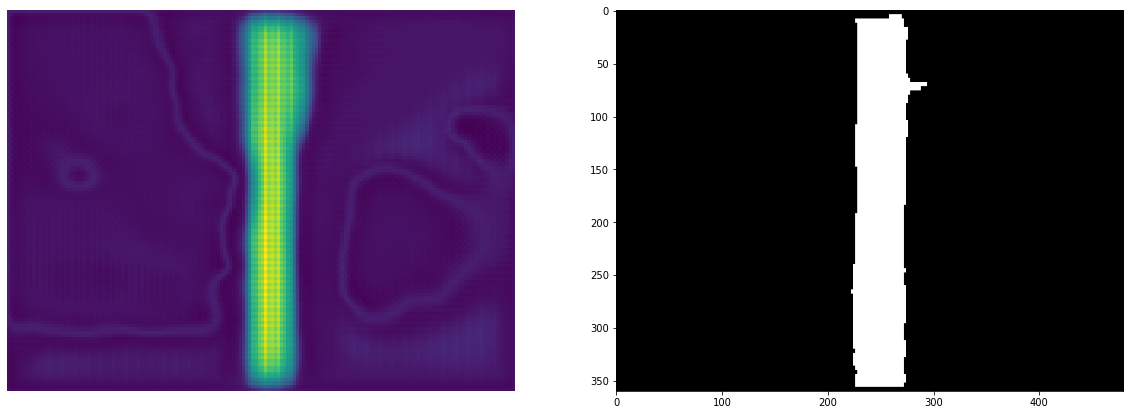

In [36]:
ncols = 2

sample_n = 0

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 4),
)

msk = test_predict[0][sample_n, :, :]
msk = torch.squeeze(msk)
axs[0].imshow(msk)
axs[0].axis("off")

gtruth = Image.open("data/debug_segment/BinaryMask_22_47.tiff")
axs[1].imshow(gtruth)

plt.savefig("data/plots/one_sample.jpg")